<a href="https://colab.research.google.com/github/SriramRajagopal42/YosemiteTalusProj/blob/main/TalusIdentifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Purpose: Import data stored in Google Drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
# Purpose: Imports

import os

import random

import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img

import PIL
from PIL import ImageOps
from PIL import Image

from sklearn.utils import shuffle

import gdal
from gdalconst import *

In [14]:
# Purpose: Basic Info

img_size = (256, 256)
num_classes = 2
num_channels = 6
batch_size = 1
tilesize = 256

satellite_file = '/content/drive/MyDrive/Yosemite/KingsCanyon_Satellite.tif' #Enter your Satellite tif file path
dem_file = '/content/drive/MyDrive/Yosemite/KingsCanyon_DEM_WGS.tif' #Enter your DEM tif file path
slope_file = '/content/drive/MyDrive/Yosemite/KingsCanyon_Slope.tif' #Enter your Slope tif file path
aspect_file = '/content/drive/MyDrive/Yosemite/KingsCanyon_Aspect.tif' #Enter your Aspect tif file path

input_dir = '/content/drive/MyDrive/MegaNumpy' #Enter your empty Input Folder directory
satellite_dir = '/content/drive/MyDrive/Chunks/SatelliteChunks' #Enter your empty Satellite Chunks Folder directory
dem_dir = '/content/drive/MyDrive/Chunks/KingsCanyonChunks' #Enter your empty DEM Chunks Folder directory
slope_dir = '/content/drive/MyDrive/Chunks/SlopeChunks' #Enter your empty Slope Chunks Folder directory
aspect_dir = '/content/drive/MyDrive/Chunks/AspectChunks' #Enter your empty Aspect Chunks Folder directory

output_dir = '/content/drive/MyDrive/TempOutput' #Enter your empty output directory to store the final image
model_dir = '/content/model.h5' #Enter your model directory

temp = Image.open(dem_file)
width, height = temp.size

In [ ]:
# Purpose: Turn all of the data into chunks, then add those chunks together and turn them into arrays

for i in range(0, width, tilesize):
    for j in range(0, height, tilesize):
        gdaltranString = "gdal_translate -of GTIFF -srcwin "+str(i)+", "+str(j)+", "+str(tilesize)+", " \
            +str(tilesize)+" " + satellite_dir + " SatelliteChunk_"+str(i)+"_"+str(j)+".tif"
        os.system(gdaltranString)
!mv SatelliteChunk* /content/drive/MyDrive/Chunks/SatelliteChunks #Enter your empty Satellite Chunks Folder directory (no quotation marks)

for i in range(0, width, tilesize):
    for j in range(0, height, tilesize):
        gdaltranString = "gdal_translate -of GTIFF -srcwin "+str(i)+", "+str(j)+", "+str(tilesize)+", " \
            +str(tilesize)+" " + dem_dir + " DEMChunk_"+str(i)+"_"+str(j)+".tif"
        os.system(gdaltranString)
!mv DEMChunk* /content/drive/MyDrive/Chunks/KingsCanyonChunks #Enter your empty DEM Chunks Folder directory (no quotation marks)

for i in range(0, width, tilesize):
    for j in range(0, height, tilesize):
        gdaltranString = "gdal_translate -of GTIFF -srcwin "+str(i)+", "+str(j)+", "+str(tilesize)+", " \
            +str(tilesize)+" " + slope_dir + " SlopeChunk_"+str(i)+"_"+str(j)+".tif"
        os.system(gdaltranString)
!mv SlopeChunk* /content/drive/MyDrive/Chunks/SlopeChunks #Enter your empty Slope Chunks Folder directory (no quotation marks)

for i in range(0, width, tilesize):
    for j in range(0, height, tilesize):
        gdaltranString = "gdal_translate -of GTIFF -srcwin "+str(i)+", "+str(j)+", "+str(tilesize)+", " \
            +str(tilesize)+" " + aspect_dir + " AspectChunk_"+str(i)+"_"+str(j)+".tif"
        os.system(gdaltranString)
!mv AspectChunk* /content/drive/MyDrive/Chunks/AspectChunks #Enter your empty Aspect Chunks Folder directory (no quotation marks)

#---------------------------------------------------------------------------------

def create_megachunk(rgb_paths, elevation_paths, slope_paths, aspect_paths):
    for f_rgb, f_ele, f_slope, f_aspect in zip(rgb_paths, elevation_paths, slope_paths, aspect_paths):
        rgb_array = np.array(load_img(f_rgb))
        r = rgb_array[..., 0]
        g = rgb_array[..., 1]
        b = rgb_array[..., 2]

        elevation = np.array(load_img(f_ele))
        elevation = elevation[..., 0]

        slope = np.array(load_img(f_slope))
        slope = slope[..., 0]

        aspect = np.array(load_img(f_aspect))
        aspect = aspect[..., 0]

        megachunk =  np.stack([r, g, b, elevation, slope, aspect], axis=-1)
        i_index, j_index = f_rgb.split(".")[0].split("_")[1:]
        np.save("megachunk_{}_{}.npy".format(i_index, j_index), megachunk)

#--------------------------------------------------------------------------------

rgbpth = sorted(
            [
                os.path.join(str(satellite_dir), fname)
                for fname in os.listdir(str(satellite_dir))
            ]
        )

dempth = sorted(
            [
                os.path.join(str(dem_dir), fname)
                for fname in os.listdir(str(dem_dir))
            ]
        )

slopepth = sorted(
            [
                os.path.join(str(slope_dir), fname)
                for fname in os.listdir(str(slope_dir))
            ]
        )

aspectpth = sorted(
            [
                os.path.join(str(aspect_dir), fname)
                for fname in os.listdir(str(aspect_dir))
            ]
        )


create_megachunk(rgbpth, dempth, slopepth, aspectpth)

!mv megachunk* /content/drive/MyDrive/MegaNumpy #Enter your empty Input Folder directory (no quotation marks)

In [15]:
# Purpose: Helper to iterate over the data (as Numpy arrays)

class TalusIdentifier(keras.utils.Sequence):

    def __init__(self, batch_size, img_size, input_img_paths, channels):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.channels = channels

    def __len__(self):
        return len(self.input_img_paths) // self.batch_size

    def __getitem__(self, idx):
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (6,), dtype="uint8")
        for j, path in enumerate(batch_input_img_paths):
            img = np.load(path)
            x[j] = img
        
        return x


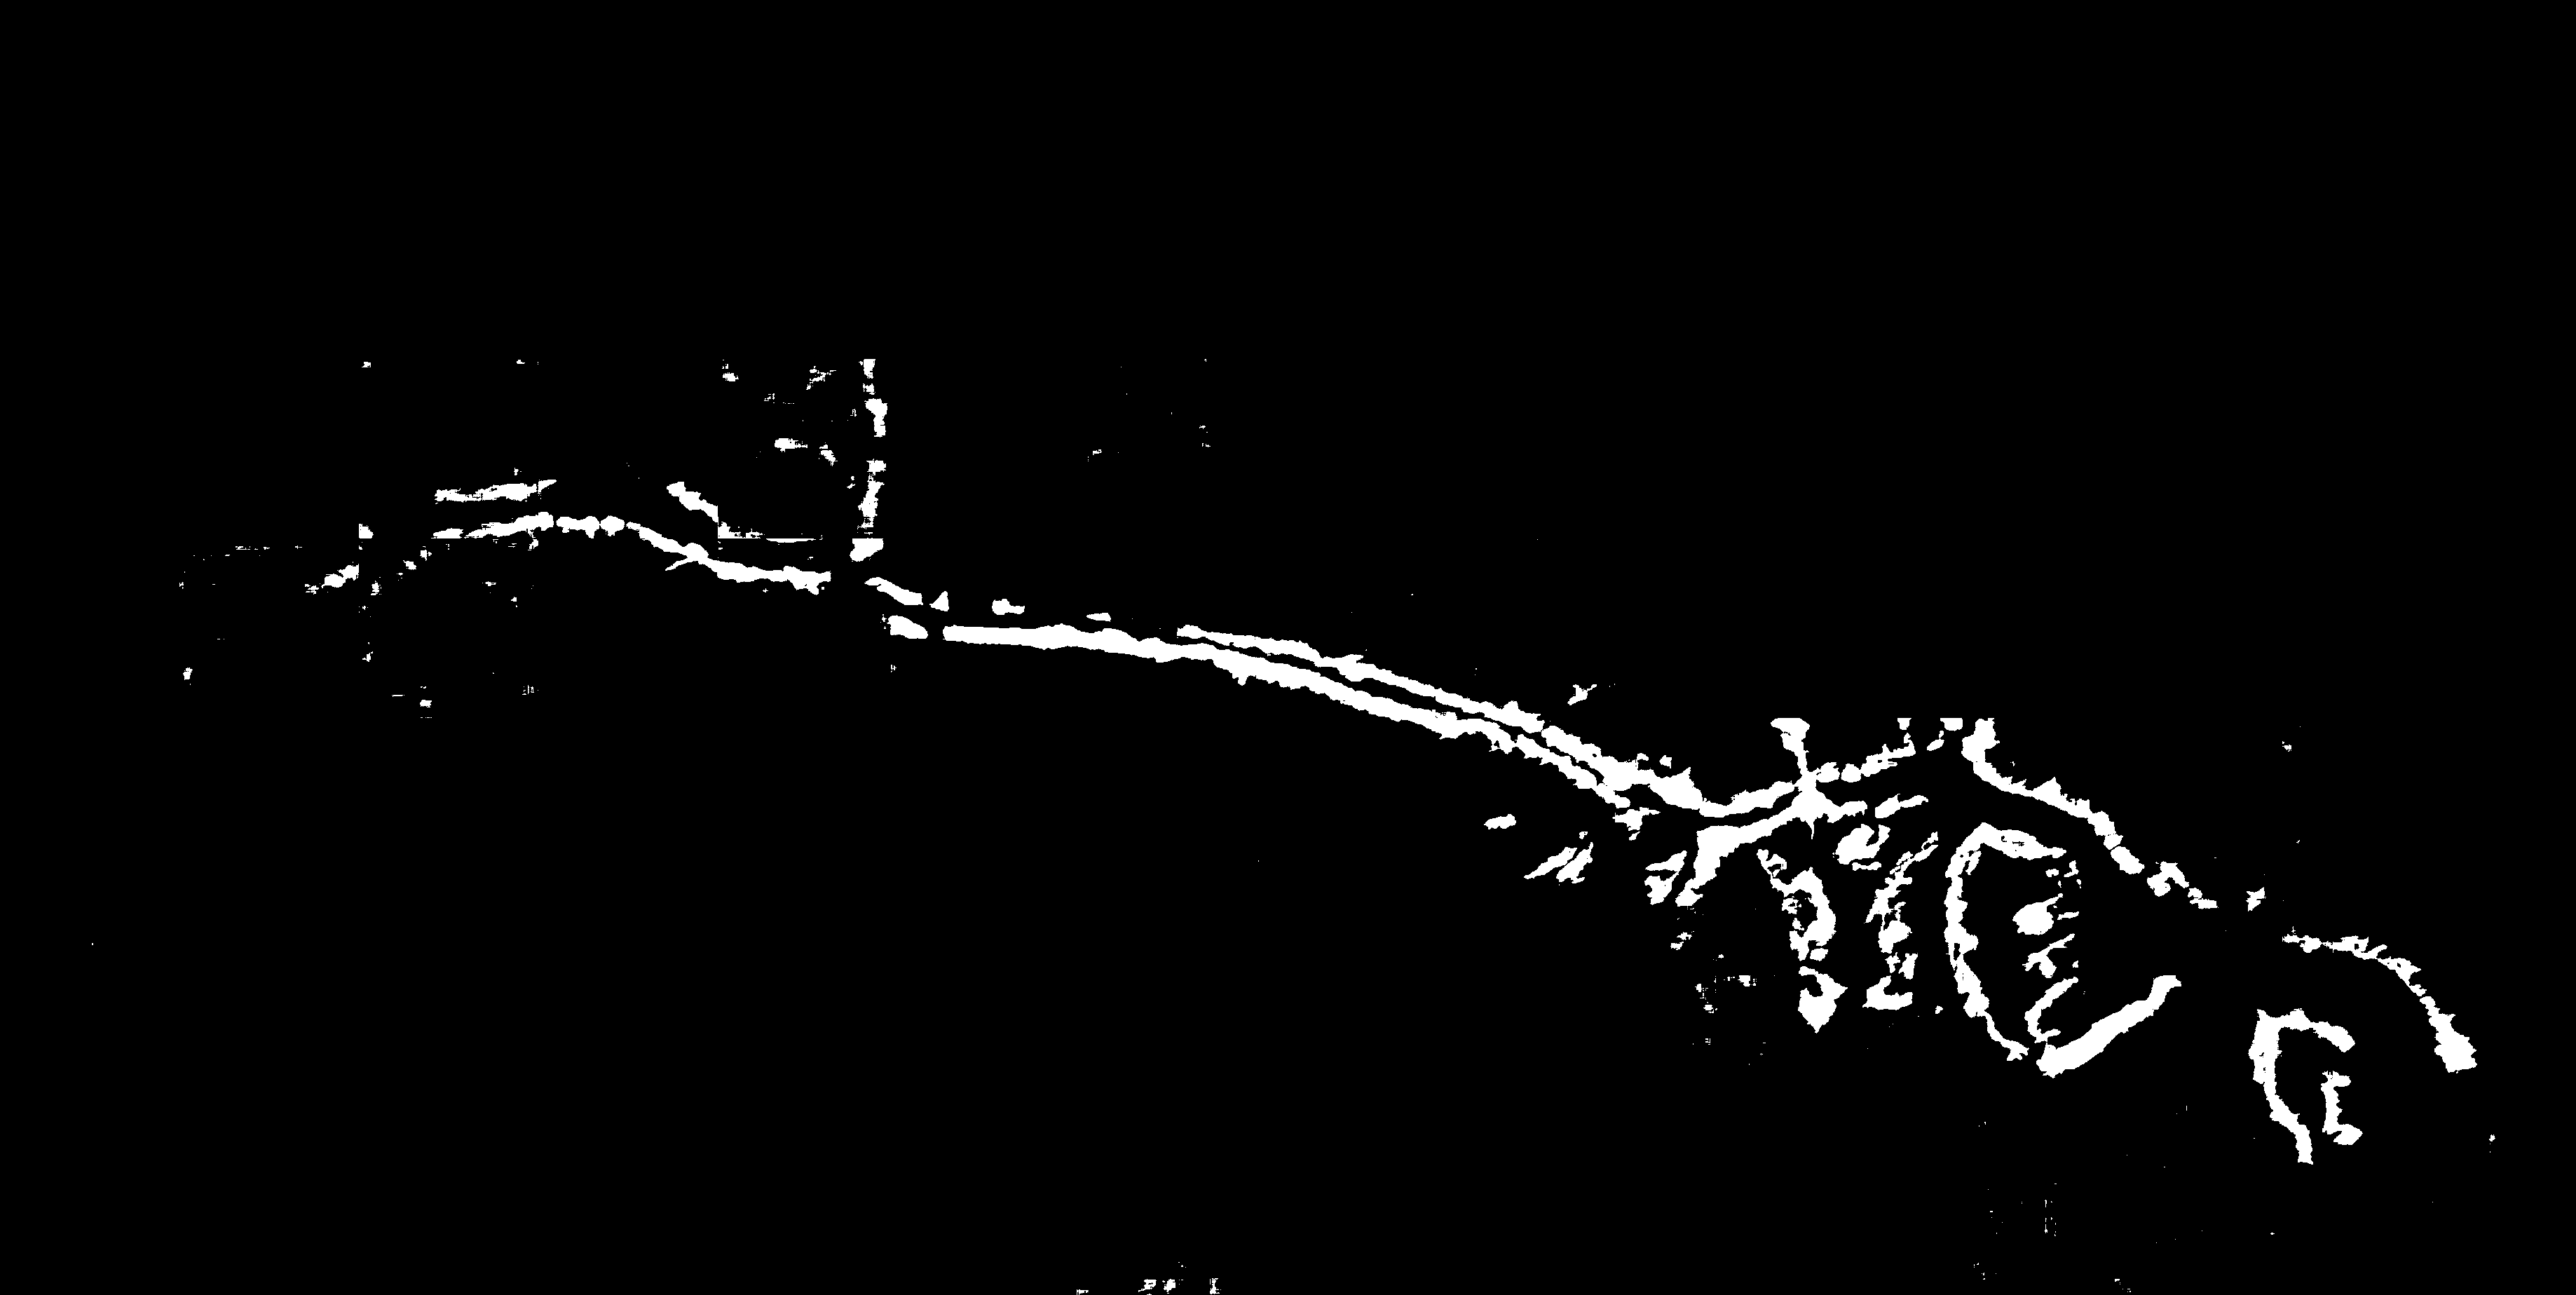

In [16]:
# Purpose: Split Data into training/validation

input_pths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
    ]
)

val_gen = TalusIdentifier(batch_size, img_size, input_pths, num_channels)

new_model = tf.keras.models.load_model(model_dir)

val_preds = new_model.predict(val_gen)

A = np.zeros((((height // 256) + 1 ) * 256, ((width // 256) + 1 ) * 256))
for i in range(len(input_pths)):
  i_start, j_start = input_pths[i].split(".")[0].split("_")[-2:]
  i_start, j_start = int(i_start), int(j_start)
  A[j_start: j_start + img_size[1], i_start: i_start + img_size[0]] = np.argmax(val_preds[i], axis=-1)

B = A[:height, :width]
B = np.expand_dims(B, axis=-1)
img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(B))
img.save(os.path.join(output_dir, 'final.jpg'))
display(img)